# Face Classifier using Convolutional Neural Network (PyTorch)

## About the Project

To classify whether an image contains human face, Deep Learning was utilised by creating a Convolutional Neural Network (CNN) using PyTorch. 

- Images of human faces were taken from: http://vis-www.cs.umass.edu/lfw/#download
- Images of animal faces were taken from: https://www.kaggle.com/andrewmvd/animal-faces#__sid=js0

The CNN model was structured using a series of different layers:

- Convolutional layer to isolate useful features from the images
- Pooling layer to facilitate dimensionality reduction and extraction of dominant features.
- Dropout layer for regularization to reduce overfitting
- Activation layer determines the output of the neural network. The activation function is attached to each neuron in the network and determines whether it should be activated or not based on whether each neuron's input is relevant for the prediction.

An accuracy of 97% was achieved using the test dataset.

## Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.optim as optim

## Loading and Pre-Processing Images

In [2]:
#convert data to tensor with necessary transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

#load data
img = datasets.ImageFolder('images', transform=transform)

## Splitting Dataset

In [3]:
#number of samples to load per batch
batch_size = 32
#percentage of data and training set to use for test and validation respectively
test_size = 0.25

#create list of indices for images
idxImg = list(range(len(img)))

#split data into train, validation and test sets
train_val, test = train_test_split(idxImg, test_size=test_size, random_state=8)
train, val = train_test_split(train_val, test_size=test_size, random_state=8)

In [4]:
#create samplers to obtain train, validation and test batches
train_sampler = SubsetRandomSampler(train)
val_sampler = SubsetRandomSampler(val)
test_sampler = SubsetRandomSampler(test)

In [5]:
#create loaders to load data from train, validation and test batches
train_loader = DataLoader(img, batch_size=batch_size, sampler=train_sampler, num_workers=1)
val_loader = DataLoader(img, batch_size=batch_size, sampler=val_sampler, num_workers=1)
test_loader = DataLoader(img, batch_size=batch_size, sampler=test_sampler, num_workers=1)

#define classes
classes = [0,1] 

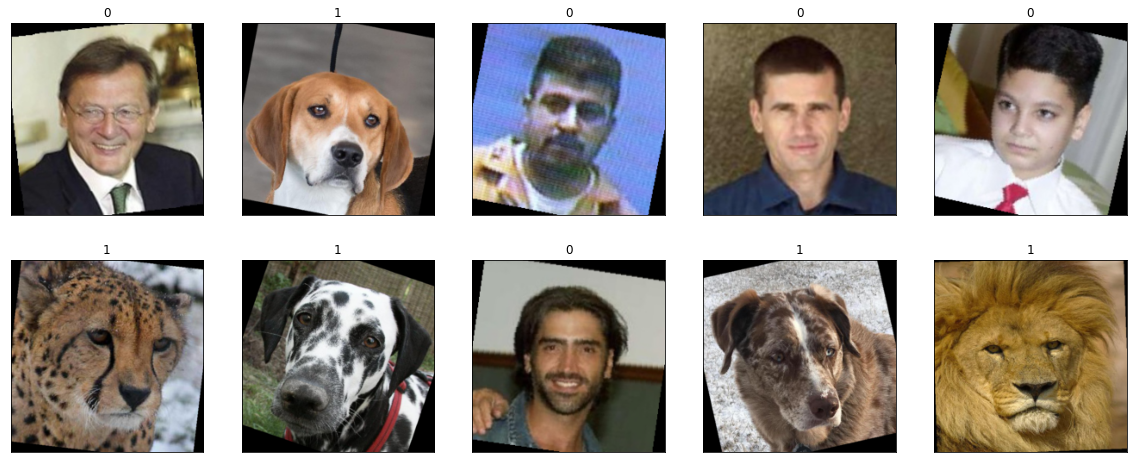

In [6]:
#function to display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize image
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor to image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in batch with corresponding labels
fig = plt.figure(figsize=(20, 8))

# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Convolution Neural Network (CNN)

In [7]:
train_on_gpu = torch.cuda.is_available()

#CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,16,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53,256)
        self.fc2 = nn.Linear(256,84)
        self.fc3 = nn.Linear(84,2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1,32*53*53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

In [8]:
#create model
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=89888, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [9]:
#move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [10]:
#define loss function
criterion = nn.CrossEntropyLoss()

#define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
#define number of epochs to train model
n_epochs = 10

#to store min validation loss
valid_loss_min = np.Inf

#to store losses
train_losses = []
valid_losses = []

for epoch in range(n_epochs+1):
    #to store training and validation losses
    train_loss = 0.0
    valid_loss = 0.0
    
    #train the model
    model.train()
    for data,target in train_loader:
        #move tensors to GPU if available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        #clear gradients of all optimized variables
        optimizer.zero_grad()
        #forward pass to compute predicted outputs by passing inputs to model 
        output = model(data)
        #compute batch loss
        loss = criterion(output, target)
        #backward pass to compute gradient of loss
        loss.backward()
        #to update parameters
        optimizer.step()
        #update training loss
        train_loss += loss.item()*data.size(0)
    
    #validating the model
    model.eval()
    for data,target in val_loader:
        #move tensors to GPU if available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        #forward pass to compute predicted outputs by passing inputs to model 
        output = model(data)
        #compute batch loss
        loss = criterion(output, target)
        #update validation loss        
        valid_loss += loss.item()*data.size(0)
    
    #compute average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    #store average losses
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pth')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 0.375089 	Validation Loss: 0.113399
Validation loss decreased (inf --> 0.113399).  Saving model ...
Epoch: 1 	Training Loss: 0.232865 	Validation Loss: 0.038475
Validation loss decreased (0.113399 --> 0.038475).  Saving model ...
Epoch: 2 	Training Loss: 0.088305 	Validation Loss: 0.021356
Validation loss decreased (0.038475 --> 0.021356).  Saving model ...
Epoch: 3 	Training Loss: 0.056907 	Validation Loss: 0.016419
Validation loss decreased (0.021356 --> 0.016419).  Saving model ...
Epoch: 4 	Training Loss: 0.055885 	Validation Loss: 0.013764
Validation loss decreased (0.016419 --> 0.013764).  Saving model ...
Epoch: 5 	Training Loss: 0.043089 	Validation Loss: 0.018870
Epoch: 6 	Training Loss: 0.041977 	Validation Loss: 0.011119
Validation loss decreased (0.013764 --> 0.011119).  Saving model ...
Epoch: 7 	Training Loss: 0.033436 	Validation Loss: 0.010235
Validation loss decreased (0.011119 --> 0.010235).  Saving model ...
Epoch: 8 	Training Loss: 0.028627 

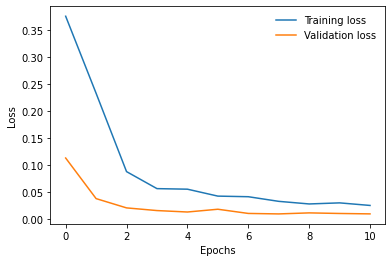

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [13]:
test_loss = 0.0
correct_class = list(0. for i in range(2))
total_class = list(0. for i in range(2))

model.eval()
i=1
# iterate over test data
for data, target in test_loader:
    i += 1
    if len(target)!=batch_size:
        continue
        
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    
    # calculate test accuracy for each object class
    
    for i in range(batch_size):       
        label = target.data[i]
        correct_class[label] += correct[i].item()
        total_class[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if total_class[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(correct_class) / np.sum(total_class),
    np.sum(correct_class), np.sum(total_class)))



Test Loss: 0.011999

Test Accuracy of     0: 98% (359/366)
Test Accuracy of     1: 97% (360/370)

Test Accuracy (Overall): 97% (719/736)
